**IMPORTING LIBRARIES**

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.preprocessing.image import  ImageDataGenerator
import skimage.io
import skimage.transform
from skimage.segmentation import slic,quickshift,mark_boundaries
import skimage.color as color
import copy
import sklearn.metrics


**IMPORTING INCEPTIONV3 MODEL**

In [6]:
model=tf.keras.applications.InceptionV3(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

**DISPLAYING MODEL ATTRIBUTES**

In [7]:
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 149, 149, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 149, 149, 32) 0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

**IMPORTING IMAGE AND PRE-PROCESSING**

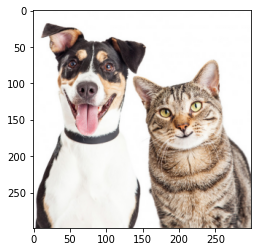

In [8]:
from keras.preprocessing import image
image_path='https://raw.githubusercontent.com/raghav-arora3/AI-Explainability-for-Multi-label-Image-Classification/main/dog%20and%20cat.jpg'
test_image=skimage.io.imread(image_path)
test_image=skimage.transform.resize(test_image, (299,299)) 
test_image = (test_image - 0.5)*2
plt.imshow(test_image/2+0.5)


**PREDICTING RESULTS AND EXTRACTING TOP 5 CLASSES**

In [9]:
preds =model.predict(test_image[np.newaxis,:,:,:])
tf.keras.applications.imagenet_utils.decode_predictions(preds,top=5)[0]

40960/35363 [==================================] - 0s 0us/step


[('n02107908', 'Appenzeller', 0.21481669),
 ('n02108000', 'EntleBucher', 0.13931721),
 ('n02123159', 'tiger_cat', 0.04467184),
 ('n02107574', 'Greater_Swiss_Mountain_dog', 0.035115685),
 ('n02110806', 'basenji', 0.033374853)]

In [10]:
top= preds[0].argsort()[-5:][::-1]
top  

array([240, 241, 282, 238, 253])

In [11]:
seg_quick=quickshift(test_image,kernel_size=4,max_dist=200,ratio=0.2)
super_p = np.unique(seg_quick).shape[0]
super_p

59

**DISPLAYING SEGMENTS OF IMAGE**

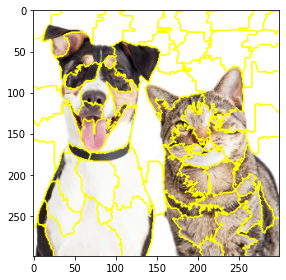

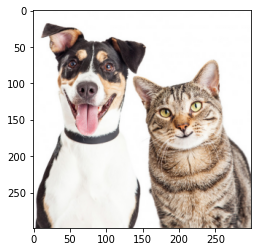

In [12]:
fig2,ax2=plt.subplots(1,1,sharex=True,sharey=True)
ax2.imshow(mark_boundaries(test_image/2+0.5,seg_quick))
plt.tight_layout()
plt.show()
plt.imshow(test_image/2+0.5)

**CREATING A RANDOM MASKS FOR SEGMENTED IMAGE**

In [13]:
perturb = 150
perturbations = np.random.binomial(1, 0.5, size=(perturb,super_p))
perturbations[0]

array([1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0])

**DEACTIVATING SUPERPIXELS i.e. GENERATING PERTURBED IMAGE**

In [14]:
def perturb_image(img,perturbation,segments):
  active_pixels = np.where(perturbation == 1)[0]
  mask = np.zeros(segments.shape)
  for active in active_pixels:
      mask[segments == active] = 1 
  perturbed_image = copy.deepcopy(img)
  perturbed_image = perturbed_image*mask[:,:,np.newaxis]
  return perturbed_image

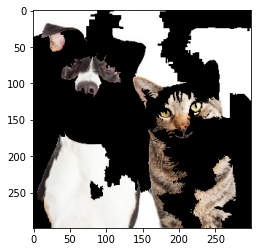

In [15]:
plt.imshow(perturb_image(test_image/2+0.5,perturbations[0],seg_quick))

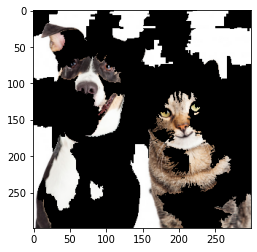

In [22]:
plt.imshow(perturb_image(test_image/2+0.5,perturbations[2],seg_quick))

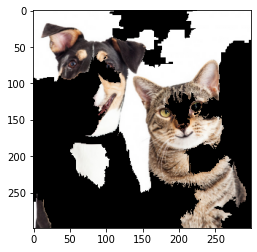

In [23]:
plt.imshow(perturb_image(test_image/2+0.5,perturbations[4],seg_quick))

**MAKING PREDICTIONS ON PERTURBED IMAGE**

In [16]:
predictions = []
for pert in perturbations:
  perturbed_img = perturb_image(test_image,pert,seg_quick)
  pred =model.predict(perturbed_img[np.newaxis,:,:,:])
  predictions.append(pred)

predictions = np.array(predictions)
predictions.shape

(150, 1, 1000)

**COMPUTING THE DISTANCE BETWEEN ORIGINAL AND PERTURBED IMAGE**

In [17]:
original = np.ones(super_p)[np.newaxis,:] 
distances = sklearn.metrics.pairwise_distances(perturbations,original, metric='cosine').ravel()
distances.shape

(150,)

In [18]:
kernel_width = 0.25
weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function
weights.shape

(150,)

**FITTING A LINEAR MODEL**

In [19]:
from sklearn.linear_model import LinearRegression
class_to_explain = top[0]
simpler_model = LinearRegression()
simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
coeff = simpler_model.coef_[0]
coeff

array([-0.00631067, -0.01155864,  0.00874364, -0.01261719,  0.01173949,
        0.01559268,  0.07988901,  0.00802967,  0.01714945, -0.00345568,
       -0.00842836,  0.02964581, -0.00596072, -0.01289239,  0.01678829,
        0.09336783,  0.00445512,  0.04768659, -0.05718148, -0.02390891,
       -0.02696791, -0.03720507, -0.02926526,  0.03494974, -0.01411468,
       -0.03436707,  0.01465987,  0.04792536, -0.0058613 ,  0.03509287,
       -0.06184229, -0.02229131, -0.02661828, -0.02312408, -0.0042024 ,
        0.00590694,  0.00877595,  0.03044806, -0.00493792, -0.01401382,
       -0.00113075, -0.02522491, -0.01059631, -0.00757739, -0.0298925 ,
       -0.00075652,  0.0211579 , -0.04293163,  0.03443731,  0.01025529,
       -0.0025643 , -0.03559513, -0.00046104, -0.00514385, -0.04388199,
       -0.02256101,  0.01399948, -0.00745957, -0.01205034])

**FINDING THE IMPORTANT SUPERPIXELS**

In [20]:
num_top_features = 4
top_features = np.argsort(coeff)[-num_top_features:] 
top_features

array([17, 27,  6, 15])

**DISPLAYING TOP FEATURES OF IMAGE**

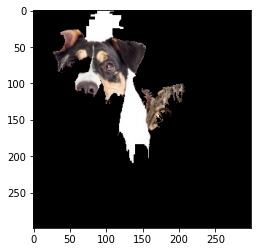

In [21]:
mask = np.zeros(super_p) 
mask[top_features]= True 
plt.imshow(perturb_image(test_image/2+0.5,mask,seg_quick))
